# 1.Wczytaj zbiór danych. Przydatna będzie funkcja scipy.io.loadmat.

In [1]:
import scipy.io

# Ścieżka do pliku .mat
file_path = 'leukemia.mat'

# Załaduj plik .mat
data = scipy.io.loadmat(file_path)

# Pobierz zmienne X i Y
X = data['X']
Y = data['Y'].flatten()  # Flatten Y to make it a 1D array

# Wyświetl kształt X i Y
print(f"Kształt X: {X.shape}")
print(f"Kształt Y: {Y.shape}")

Kształt X: (72, 7070)
Kształt Y: (72,)


In [2]:
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Wed Mar 25 15:23:42 2015',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[-2,  2,  0, ...,  2,  0,  0],
        [ 0,  0,  0, ...,  0, -2,  0],
        [-2, -2,  0, ...,  2,  0,  0],
        ...,
        [ 2,  2,  0, ...,  0,  0,  2],
        [ 0, -2,  0, ...,  0,  0, -2],
        [ 2, -2,  0, ...,  0,  0, -2]], dtype=int16),
 'Y': array([[-1],
        [-1],
        [-1],
        [-1],
        [-1],
        [-1],
        [-1],
        [-1],
        [-1],
        [-1],
        [-1],
        [-1],
        [-1],
        [-1],
        [-1],
        [-1],
        [-1],
        [-1],
        [-1],
        [-1],
        [-1],
        [-1],
        [-1],
        [-1],
        [-1],
        [-1],
        [-1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [-1],
        [-1],
        [-1],
        [-1],
 

## Jak można zauważyć, cechy nie mają żadnych nazw

# 2.Usuń cechy charakteryzujące się niską wariancją, tj. takie, których wariancja jest niższa niż pewien ustalony próg. Porównaj skuteczność predykcji na oryginalnym zbiorze i po usunięciu cech o niskiej wariancji

In [3]:
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def train_and_evaluate(X, Y):
    # Podział na zbiór treningowy i testowy
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
    
    # Trenowanie modelu
    model = LogisticRegression(max_iter=10000, class_weight='balanced', solver='liblinear')
    model.fit(X_train, Y_train)
    
    # Predykcje
    Y_pred = model.predict(X_test)
    
    # Obliczanie dokładności
    accuracy = accuracy_score(Y_test, Y_pred)
    return accuracy

In [4]:
# Lista progów do przetestowania
thresholds = [i*0.05 for i in range(1,67)]

# Przechowywanie wyników
results = []

for threshold in thresholds:
    selector = VarianceThreshold(threshold=threshold)
    X_reduced = selector.fit_transform(X)
    
    accuracy_reduced = train_and_evaluate(X_reduced, Y)
    
    results.append((threshold, X_reduced.shape[1], accuracy_reduced))

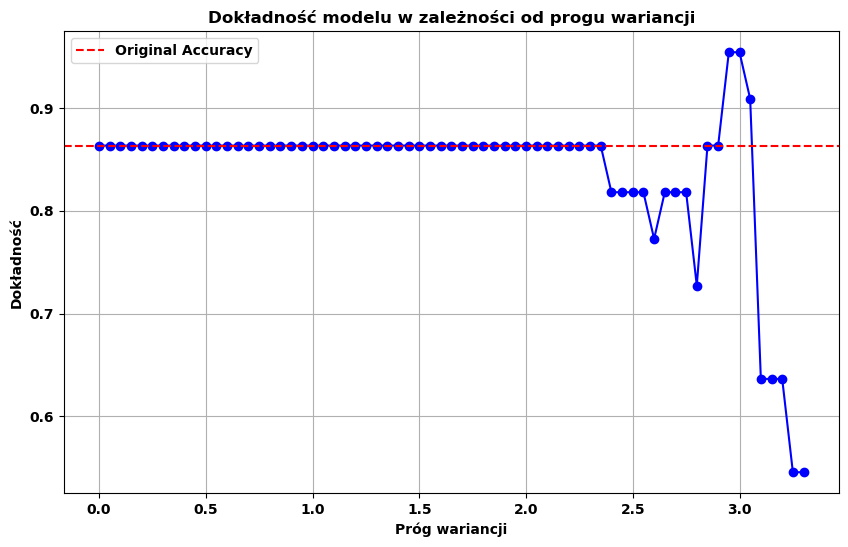

In [5]:
import matplotlib.pyplot as plt

accuracy_original = train_and_evaluate(X, Y)

# Dodanie wyniku dla oryginalnego zbioru danych do wyników
results.append((0, X.shape[1], accuracy_original))

# Sortowanie wyników według progu wariancji
results.sort()

# Tworzenie wykresu
thresholds = [r[0] for r in results]
num_features = [r[1] for r in results]
accuracies = [r[2] for r in results]

plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracies, marker='o', linestyle='-', color='b')
plt.axhline(y=accuracy_original, color='r', linestyle='--', label='Original Accuracy')
plt.title('Dokładność modelu w zależności od progu wariancji')
plt.xlabel('Próg wariancji')
plt.ylabel('Dokładność')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# Dokładność na oryginalnym zbiorze danych
accuracy_original = train_and_evaluate(X, Y)
print(f"Dokładność na oryginalnym zbiorze danych: {accuracy_original:.4f}")

# Znalezienie elementu z największą dokładnością
best_result = max(results, key=lambda x: x[2])
print(f"Najlepszy wynik: Próg: {best_result[0]}, Liczba cech: {best_result[1]}, Dokładność: {best_result[2]:.4f}")

Dokładność na oryginalnym zbiorze danych: 0.8636
Najlepszy wynik: Próg: 2.95, Liczba cech: 32, Dokładność: 0.9545


## Wybrano próg z najlepszą dokładnością

In [7]:
# Wybrany próg
threshold = 2.95

selector = VarianceThreshold(threshold=threshold)
X_reduced = selector.fit_transform(X)

print(f"Kształt X po usunięciu cech o niskiej wariancji: {X_reduced.shape}")

Kształt X po usunięciu cech o niskiej wariancji: (72, 32)


# 3. Z powstałego zbioru cech wybierz m najlepszych cech, stosując algorytm rekursywnej eliminacji cech (ang. Recursive Feature Elimination, RFE).

In [8]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

def feature_selection_rfe(X, Y, estimator, n_features_to_select):
    rfe = RFE(estimator=estimator, n_features_to_select=n_features_to_select)
    X_rfe = rfe.fit_transform(X, Y)
    return X_rfe, rfe

In [9]:
# Podział na zbiór treningowy i testowy
X_train, X_test, Y_train, Y_test = train_test_split(X_reduced, Y, test_size=0.3, random_state=42)

# Liczba cech do pozostawienia (m < n/3)
n_features_to_select = Y.shape[0] // 3

# Regresja logistyczna
log_reg = LogisticRegression(max_iter=10000, class_weight='balanced', solver='liblinear')

# Selekcja cech za pomocą RFE
X_train_rfe, rfe_log_reg = feature_selection_rfe(X_train, Y_train, log_reg, n_features_to_select)
X_test_rfe = rfe_log_reg.transform(X_test)

# Trenowanie modelu i ocena
log_reg.fit(X_train_rfe, Y_train)
accuracy_rfe_log_reg = accuracy_score(Y_test, log_reg.predict(X_test_rfe))
print(f"Dokładność RFE z regresją logistyczną: {accuracy_rfe_log_reg:.4f}")

# Lasy losowe
random_forest = RandomForestClassifier(n_estimators=18, random_state=42, class_weight='balanced')

# Selekcja cech za pomocą RFE
X_train_rfe_rf, rfe_rf = feature_selection_rfe(X_train, Y_train, random_forest, n_features_to_select)
X_test_rfe_rf = rfe_rf.transform(X_test)

# Trenowanie modelu i ocena
random_forest.fit(X_train_rfe_rf, Y_train)
accuracy_rfe_rf = accuracy_score(Y_test, random_forest.predict(X_test_rfe_rf))
print(f"Dokładność RFE z lasami losowymi: {accuracy_rfe_rf:.4f}")

Dokładność RFE z regresją logistyczną: 0.9091
Dokładność RFE z lasami losowymi: 0.9545


In [10]:
log_reg_coef = log_reg.coef_[0]
feature_importance_log_reg = abs(log_reg_coef) / sum(abs(log_reg_coef))
feature_importance_log_reg[::-1].sort()

print("Ważność cech dla regresji logistycznej:")
for i, importance in enumerate(feature_importance_log_reg):
    print(f"Cecha {i+1}: {importance:.4f}")

Ważność cech dla regresji logistycznej:
Cecha 1: 0.1738
Cecha 2: 0.1193
Cecha 3: 0.0626
Cecha 4: 0.0531
Cecha 5: 0.0519
Cecha 6: 0.0507
Cecha 7: 0.0453
Cecha 8: 0.0442
Cecha 9: 0.0405
Cecha 10: 0.0381
Cecha 11: 0.0358
Cecha 12: 0.0326
Cecha 13: 0.0318
Cecha 14: 0.0315
Cecha 15: 0.0308
Cecha 16: 0.0307
Cecha 17: 0.0229
Cecha 18: 0.0222
Cecha 19: 0.0166
Cecha 20: 0.0164
Cecha 21: 0.0153
Cecha 22: 0.0142
Cecha 23: 0.0127
Cecha 24: 0.0069


In [11]:
feature_importance_rf = random_forest.feature_importances_
feature_importance_rf[::-1].sort()

print("\nWażność cech dla lasów losowych:")
for i, importance in enumerate(feature_importance_rf):
    print(f"Cecha {i+1}: {importance:.4f}")


Ważność cech dla lasów losowych:
Cecha 1: 0.3157
Cecha 2: 0.1998
Cecha 3: 0.0884
Cecha 4: 0.0669
Cecha 5: 0.0608
Cecha 6: 0.0546
Cecha 7: 0.0371
Cecha 8: 0.0224
Cecha 9: 0.0223
Cecha 10: 0.0191
Cecha 11: 0.0185
Cecha 12: 0.0170
Cecha 13: 0.0111
Cecha 14: 0.0108
Cecha 15: 0.0099
Cecha 16: 0.0096
Cecha 17: 0.0096
Cecha 18: 0.0048
Cecha 19: 0.0047
Cecha 20: 0.0045
Cecha 21: 0.0044
Cecha 22: 0.0042
Cecha 23: 0.0035
Cecha 24: 0.0002


## Wnioski 
### W przypadku regresji logistycznej, cechy mają bardziej jednorodne znaczenie, podczas gdy w lasach losowych pewne cechy są bardziej dominujące niż inne.
### Może to sugerować, że regresja logistyczna skupia się na mniejszej liczbie istotnych cech w porównaniu do lasów losowych oraz  że lasy losowe mogą bardziej różnicować znaczenie różnych cech w procesie klasyfikacji.

# 4. Zbadaj wpływ dwóch metryk: dokładności oraz metryki AUC na dokładność klasyfikacji przy użyciu regresji logistycznej oraz lasów losowych. Zastosuj cztero lub sześciokrotną walidację krzyżową

In [12]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, roc_auc_score

# Inicjalizacja klasyfikatora regresji logistycznej
log_reg = LogisticRegression(max_iter=10000, class_weight='balanced', solver='liblinear')

# Walidacja krzyżowa z dwiema metrykami: dokładności i metryką AUC
accuracy_scores_log_reg = cross_val_score(log_reg, X, Y, cv=6, scoring='accuracy')
auc_scores_log_reg = cross_val_score(log_reg, X, Y, cv=6, scoring='roc_auc')


# Inicjalizacja klasyfikatora lasów losowych
random_forest = RandomForestClassifier(n_estimators=18, random_state=42, class_weight='balanced')

# Walidacja krzyżowa z dwiema metrykami: dokładności i metryką AUC
accuracy_scores_rf = cross_val_score(random_forest, X, Y, cv=6, scoring='accuracy')
auc_scores_rf = cross_val_score(random_forest, X, Y, cv=6, scoring='roc_auc')

In [13]:
# Średnia dokładność i AUC dla regresji logistycznej
cross_validation_accuracy_log_reg = accuracy_scores_log_reg.mean()
cross_validation_accuracy_rf = accuracy_scores_rf.mean()

print(f"Średnia dokładność dla regresji logistycznej: {cross_validation_accuracy_log_reg:.4f}")
print(f"Średnia dokładność dla lasów losowych: {cross_validation_accuracy_rf:.4f}")
print()

# Średnia dokładność i AUC dla lasów losowych
cross_validation_auc_log_reg = auc_scores_log_reg.mean()
cross_validation_auc_rf = auc_scores_rf.mean()

print(f"Średnia metryka AUC dla regresji logistycznej: {cross_validation_auc_log_reg:.4f}")
print(f"Średnia metryka AUC dla lasów losowych: {cross_validation_auc_rf:.4f}")

Średnia dokładność dla regresji logistycznej: 0.9167
Średnia dokładność dla lasów losowych: 0.9306

Średnia metryka AUC dla regresji logistycznej: 0.9857
Średnia metryka AUC dla lasów losowych: 0.9829


## Wnioski 
### Wartości dokładności oraz AUC dla regresji logistycznej oraz lasów losowych są do siebie bardziej zbliżone niż w przypadku użycia RFE.
### Walidacja krzyżowa jest bardziej wiarygodnym sposobem oceny wydajności modelu, ponieważ bierze pod uwagę uogólnienie modelu na różnych podzbiorach danych treningowych i testowych. Dzięki temu model jest oceniany na szerszym spektrum danych, co może prowadzić do bardziej stabilnych wyników.


# 5. Porównaj skuteczność (tzn. dokładność) zastosowanego podejścia z wbudowanymi metodami selekcji cech:

In [14]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Inicjalizacja regresji logistycznej z regularyzacją L1
log_reg_l1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000, class_weight='balanced')

# Utworzenie obiektu SelectFromModel z regularyzacją L1
selector_l1 = SelectFromModel(estimator=log_reg_l1)

# Dopasowanie selektora do danych treningowych
selector_l1.fit(X_train, Y_train)

# Zastosowanie selektora do danych treningowych i testowych
X_train_selected_l1 = selector_l1.transform(X_train)
X_test_selected_l1 = selector_l1.transform(X_test)

# Trenowanie modelu regresji logistycznej na danych z wybranymi cechami
log_reg_l1.fit(X_train_selected_l1, Y_train)

# Ocena dokładności modelu na danych testowych
accuracy_l1 = accuracy_score(Y_test, log_reg_l1.predict(X_test_selected_l1))
print(f"Dokładność regresji logistycznej po selekcji cech L1: {accuracy_l1:.4f}")

Dokładność regresji logistycznej po selekcji cech L1: 0.9091


In [15]:
# Inicjalizacja lasów losowych
random_forest = RandomForestClassifier(n_estimators=18, random_state=42, class_weight='balanced')

# Utworzenie obiektu SelectFromModel z lasami losowymi
selector_rf = SelectFromModel(estimator=random_forest)

# Dopasowanie selektora do danych treningowych
selector_rf.fit(X_train, Y_train)

# Zastosowanie selektora do danych treningowych i testowych
X_train_selected_rf = selector_rf.transform(X_train)
X_test_selected_rf = selector_rf.transform(X_test)

# Trenowanie modelu lasów losowych na danych z wybranymi cechami
random_forest.fit(X_train_selected_rf, Y_train)

# Ocena dokładności modelu na danych testowych
accuracy_rf = accuracy_score(Y_test, random_forest.predict(X_test_selected_rf))
print(f"Dokładność lasów losowych po selekcji cech RF: {accuracy_rf:.4f}")

Dokładność lasów losowych po selekcji cech RF: 0.9091


In [16]:
accuracy_values = [
    ("Original Accuracy                            ", accuracy_original),
    ("RFE with Logistic Regression                 ", accuracy_rfe_log_reg),
    ("RFE with Random Forest                       ", accuracy_rfe_rf),
    ("Cross validation Accuracy Logistic Regression", cross_validation_accuracy_log_reg),
    ("Cross validation Accuracy Random Forest      ", cross_validation_accuracy_rf),
    ("Accuracy with L1 Regularization              ", accuracy_l1),
    ("Accuracy with Random Forest                  ", accuracy_rf)
]

sorted_accuracy_values = sorted(accuracy_values, key=lambda x: x[1], reverse=True)

for label, accuracy in sorted_accuracy_values:
    print(f"{label}:  {accuracy:.4f}")

RFE with Random Forest                       :  0.9545
Cross validation Accuracy Random Forest      :  0.9306
Cross validation Accuracy Logistic Regression:  0.9167
RFE with Logistic Regression                 :  0.9091
Accuracy with L1 Regularization              :  0.9091
Accuracy with Random Forest                  :  0.9091
Original Accuracy                            :  0.8636


## Wnioski
### Metoda RFE z lasami losowymi osiągnęła najwyższą dokładność: Wyniki pokazują, że metoda eliminacji cech z wykorzystaniem lasów losowych (RFE with Random Forest) osiągnęła najwyższą dokładność spośród wszystkich testowanych metod. Świadczy to o skuteczności tej metody w identyfikacji istotnych cech i budowaniu efektywnego modelu klasyfikacyjnego.
### Wyniki walidacji krzyżowej dla obu modeli - lasów losowych i regresji logistycznej - są zbliżone i utrzymują się na wysokim poziomie. Świadczy to o stabilności i zdolności generalizacji obu modeli na różnych podzbiorach danych.
### Wbudowane metody selekcji cech okazały się być lepsze od podstawowej klasyfikacji jednakże metoda RFE oraz walidacja krzyżowa daje zauważalnie lepsze wyniki